# **Analisis de sentimientos de comentarios de películas**

### Integrantes:
* Ángela Vargas
* Juan Martin Santos
* Daniel Osorio

## **Caso**
Análisis de sentimientos de películas. Este proyecto tiene comentarios de películas
en español, que deben ser clasificadas en las categorías de positivo, negativo. Esto por medio de técnicas para el procesamiento de lenguaje natural.

## **Entendimiento de los datos**
Primero vamos a cargar los datos en un DataFrame para luego revisar la calidad de estos en cuanto a completitud, consistencia y unicidad.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
# Se descargan las stopwords (despues se usan para eliminar palabras que no aportan informacion)
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from langdetect import detect
# Este comando es requerido para que las visualizaciones se muestren en este notebook
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jm200\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
pd.set_option('display.max_columns', None) # Número máximo de columnas a mostrar
pd.set_option('display.max_rows', 50) # Numero máximo de filas a mostar

In [3]:
# Lectura de datos en formato CSV
# Los datos son almacenados en memoria usando una estructura de datos de Pandas conocida como dataframe
df_reviews = pd.read_csv('./data/MovieReviews.csv')

In [4]:
# Muestra el numero de filas y columnas del dataframe
df_reviews.shape

(5000, 3)

In [5]:
# Muestra de 5 filas aleatorias del dataframe
df_reviews.sample(5)

,Unnamed: 0,review_es,sentimiento
3530,3530,Creo que las tarjetas fueron apiladas contra e...,negativo
1133,1133,"""Sasquatch Hunters"" en realidad no era tan mal...",positivo
4207,4207,Podría contener spoilers ... Estoy sorprendido...,negativo
4090,4090,"Chuck Norris Estrellas como Danny, un policía ...",negativo
1534,1534,Vi esta película puramente por casualidad. Se ...,positivo


In [6]:
# Muestra el tipo de datos de cada columna
df_reviews.dtypes

Unnamed: 0      int64
review_es      object
sentimiento    object
dtype: object

In [7]:
# Muestra los diferentes valores de la columna sentimiento
df_reviews['sentimiento'].value_counts()

positivo    2500
negativo    2500
Name: sentimiento, dtype: int64

Como podemos observar, tenemos 5000 registros (reviews) de los cuales la mitad corresponden a reviews positivas y la otra mitad a reviews negativas. Existe consistencia en los valores de la columna sentimiento. Como existen 2500 positivos y 2500 negativos, podemos decir que la completitud de los datos para la columna sentimiento es del 100%, vamos a revisar ahora la completitud para la columna *review_es*.

In [8]:
# Muestra la cantidad de valores nulos para la columna review_es
df_reviews['review_es'].isnull().sum()

0

Ahora, verificaremos la unicidad de los valores de la columnas "review_es". Este paso es importante ya que al identificar registros duplicados, podemos tomar medidas que nos ayudan a mejorar la precision y eficiencia de los modelos que realizaremos.

In [11]:
df_reviews['review_es'].duplicated().sum()

2

Por ultimo, verificaremos el idioma en el que se encuentran los comentarios.

In [19]:
# Primero creamos el diccionario de los idiomas en los que estan los comentarios
langs = {}

# Luego iteramos sobre cada comentario y determinamos su idioma
for index, row in df_reviews.iterrows():
    if detect(row['review_es']) not in langs:
        langs[detect(row['review_es'])] = 1
    else:
        langs[detect(row['review_es'])] += 1

print(langs)

{'es': 4803, 'en': 196, 'id': 1}


Como podemos observar, tenemos una completitud del 100% en la columna review_es, por lo que no es necesario realizar ningún tipo de limpieza de datos a nivel de intregridad y completitud de los datos. Sin embargo, nos percatamos que dentro del conjunto de datos hay comentarios que no estan en español y que hay comentarios repetidos, por lo que obtaremos por eliminar estas filas, esta decision se toma debido a las necesidades del negocio de analisar comentarios en español.
## **Preprocesamiento**


Para encargarnos de los comentarios repetidos obtamos por eliminar los registros. Estos no significan una gran parte de los datos por lo que quitarlos nos ayudara en el mejor funcionamiento del algoritmo

In [20]:
df_reviews['review_es'].drop_duplicates(inplace=True)

Como libreria para limpiar las filas con los comentarios en ingles usaremos langdetect que nos permitira tomar todo el comentario y determinar el idioma en el que esta.

In [21]:
#Iteramos en cada una de las filas del dataframe
for index, row in df_reviews.iterrows():
    # Si el valor de la fila es en la elimina
    if detect(row['review_es']) != 'es':
        df_reviews.drop(index, inplace=True)

Como libreria para el procesamiento de lenguaje natural vamos a utilizar NLTK (Natural Language Tool Kit). Primero definimos un set de stopwords en español. Las stopwords son esas palabras que no aportan significado al texto para la tarea de clasificación. Estas palabras vacías pueden ser conectores propios del idioma, pronombres o puntos y comas. Algunas stopwords del español son por ejemplo las siguientes.

In [22]:
# Seteamos las stopwords en español
stop_words = set(stopwords.words('spanish'))
# Agregamos a las stopwords tambien los signos de puntuacion
# Se agrega una u a la izquierda para indicar que es un string unicode, sin embargo no es necesario
stop_words = list(stop_words)
stop_words.extend([u'.', u'[', ']', u',', u';', u'', u')', u'),', u' ', u'('])
print(stop_words)

['estará', 'nos', 'estaba', 'estuvieran', 'tuvieseis', 'sea', 'estarías', 'por', 'fueran', 'yo', 'hay', 'habrás', 'fuéramos', 'estadas', 'hubiste', 'estén', 'han', 'estamos', 'fuera', 'tendremos', 'estemos', 'mío', 'qué', 'haya', 'será', 'antes', 'tendrían', 'estarás', 'no', 'ni', 'tendré', 'el', 'ante', 'tuviéramos', 'estada', 'todos', 'estaríais', 'hayamos', 'había', 'seríamos', 'habido', 'tú', 'tendría', 'habría', 'vosotros', 'cual', 'tengo', 'su', 'estarán', 'tienes', 'soy', 'desde', 'fuimos', 'o', 'eran', 'fui', 'estuviéramos', 'habidas', 'esos', 'estés', 'ha', 'habrías', 'vuestro', 'sentidos', 'estaríamos', 'les', 'sean', 'habríais', 'habían', 'donde', 'estás', 'seríais', 'estuviésemos', 'se', 'sentida', 'ese', 'otra', 'hubieras', 'hayas', 'ya', 'otros', 'vosotras', 'hayáis', 'hubiesen', 'hubiésemos', 'fueras', 'tuyo', 'estad', 'tendríamos', 'está', 'habíamos', 'seamos', 'vuestros', 'otras', 'hubiese', 'tuvierais', 'tenían', 'estaremos', 'tuvisteis', 'mí', 'lo', 'fueron', 'quien'

Luego se utiliza el Snowball stemming algorithm, este algoritmo lo que hace es transformar/reducir las palabras a su forma base, aqui hacemos un ejemplo con la palabra 'corriendo' y 'correr'

In [23]:
snowball_stemmer = SnowballStemmer('spanish')
snowball_stemmer.stem('corriendo')

'corr'

In [24]:
snowball_stemmer.stem('correr')

'corr'

Para tokenizar utilizamos la función *wordpunct_tokenize()* que tiene la libreria NLTK. Esta función, a diferencia de la función *word_tokenize()*, almacena los signos de puntuación como tokens diferentes. El *word.isapha()* es para revisar que la palabra no sea de una sola letra como por ejemplo 'y'. Luego se revisa que la palabra en minuscula no esté entre las stopwords antes de tokenizarla. A continuación un ejemplo de como funciona

In [25]:
# Ejemplo de como se tokenizan las palabras de una reseña
review_example = "Este es un ejemplo de una reseña en español."
review_tokens = [word.lower() for word in wordpunct_tokenize(review_example) if word.isalpha() and word.lower() not in stop_words]
print(review_tokens)

['ejemplo', 'reseña', 'español']


Ahora aplicamos esto para cada fila de la columna 'review_es'. Para esto definimos la funcion lamba a cada fila de la columna review utilizando el metodo apply. Se hace todo el proceso de tokenizacion mostrado anteriormente y se vuelve a juntar el texto con el metodo join(). El string resultante es ahora el nuevo valor para la fila en la columna 'review_es'.

In [26]:
df_reviews['review_es'] = df_reviews['review_es'].apply(lambda x: ' '.join([snowball_stemmer.stem(word.lower()) for word in wordpunct_tokenize(x) if (word.isalpha() and word.lower() not in stop_words)]))

In [27]:
df_reviews['review_es'].head(5)

0    si busc pelicul guerr tipic asi not aficion gu...
1    supong director pelicul luj sent busc abrig gr...
2    dificil cont pelicul estrop disfrut esper vien...
3    pelicul comienz lent estil vid wallac napalm a...
4    pelicul verdader accion maxim expresion mejor ...
Name: review_es, dtype: object

Usamos el *CountVectorizer()* que nos da la cuenta de cada de cada palabra para cada review, lo cual podemos usar para los modelos que crearemos a continuación.

In [28]:
# Extraer la cuenta de cada palabra para cada review
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_reviews['review_es'])
y = df_reviews['sentimiento']

In [29]:
# Dividimos los datos en entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## **Modelos**

### **Multinomial Naive Bayes**

Escogimos este algoritmo porque trabaja muy bien con datos discretos, lo cual lo hace especialmente bueno para una tarea de clasificacion como si el comentario es positivo o negativo. El algoritmo realiza el calculo de la probabilidad de que cada palabra de una review pertenezca a una clase (positivo o negativo) y luego utiliza estas probabilidades con el teorema de Bayes para calcular la probabilidad de que una review pertenezca a una clase. El algoritmo asume que la probabilidad de una palabra es independiente de las otras, por lo cual es llamado 'naive' Bayes.

In [30]:
# Entrenar el modelo
multinomialNB = MultinomialNB()
multinomialNB.fit(X_train, y_train)

# Predicción
y_train_pred = multinomialNB.predict(X_train)
y_pred = multinomialNB.predict(X_test)

# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred))
print("Recall: {}".format(recall_score(y_test, y_pred, pos_label='positivo')))
print("Precisión: {}".format(precision_score(y_test, y_pred, pos_label='positivo')))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred, pos_label='positivo')))

Exactitud sobre test: 0.82
Recall: 0.8012684989429175
Precisión: 0.8293216630196937
Puntuación F1: 0.8150537634408603


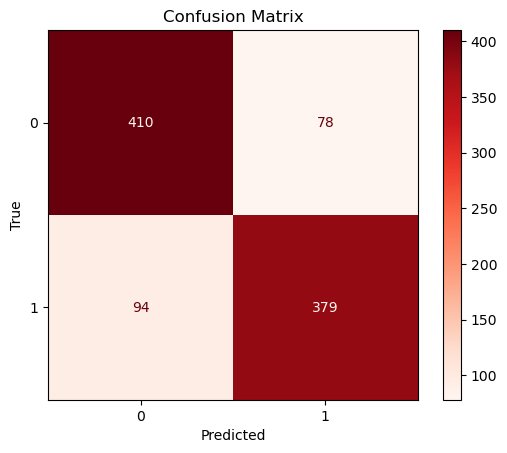

In [31]:
# Matriz de confusion
cm = confusion_matrix(y_test, y_pred)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()

### Random forest
Escogimos este algoritmo porque este es capaz de manejar caracteristicas de alta dimension lo que favorece en el analisis de texto por la extension de los mismos. Ademas, maneja muy bien el overfitting. El algoritmo se basa en arboles de decision y funciona de la siguiente forma: Selecciona aleatoriamente un subconjunto de muestras; Selecciona aleatoriamente un subconjunto de caracteristicas; con las muestras y caracteristicas seleccionadas se construyen varios arboles de decision; por ultimo se selecciona el arbol de decision que obtiene mayor votacion dados sus resultados.

In [32]:
# Creamos el clasificador de random forest con 100 arboles
rf = RandomForestClassifier(n_estimators=100, random_state=0)
# Entrenamos el modelo
y_train_pred_rf = rf.fit(X_train, y_train)
# Realizamos la predicción
y_pred_rf = rf.predict(X_test)

# Metricas de evaluacion
print('Exactitud sobre test: %.2f' % accuracy_score(y_test, y_pred_rf))
print("Recall: {}".format(recall_score(y_test, y_pred_rf, pos_label='positivo')))
print("Precisión: {}".format(precision_score(y_test, y_pred_rf, pos_label='positivo')))
print("Puntuación F1: {}".format(f1_score(y_test, y_pred_rf, pos_label='positivo')))

Exactitud sobre test: 0.84
Recall: 0.8456659619450317
Precisión: 0.8247422680412371
Puntuación F1: 0.8350730688935282


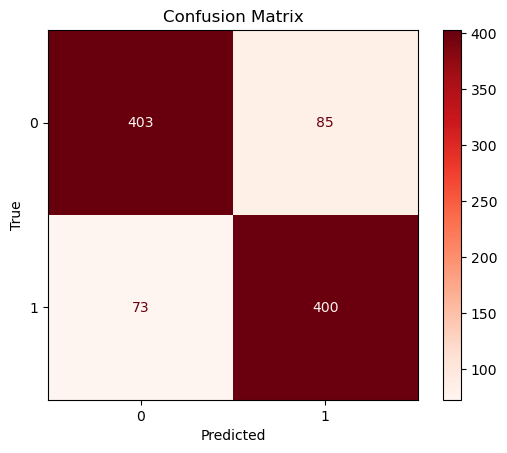

In [33]:
# Matriz de confusion
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Crear una instancia de ConfusionMatrixDisplay con la matriz de confusión
cm_rf_display = ConfusionMatrixDisplay(confusion_matrix=cm_rf)

# Mostrar la matriz de confusión utilizando la función plot() de ConfusionMatrixDisplay
cm_rf_display.plot(cmap='Reds')

# Añadir etiquetas y títulos
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Mostrar la matriz de confusión
plt.show()